<a href="https://colab.research.google.com/github/alexandrufalk/Background-generator/blob/Layout-page/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is a time series problem?
Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.
Problem Type	Examples	Output
Classification	Anomaly detection, time series identification (where did this time series come from?)	Discrete (a label)
Forecasting	Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements	Continuous (a number)



#Get data

In [1]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2024-08-21 04:26:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2024-08-21 04:26:57 (41.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#Importing time series data with pandas

In [2]:
#import with pandas
import pandas as pd
# Parse dates and set date column to index
df=pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
               parse_dates=["Date"],
               index_col=["Date"]
               ) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(df)

2787

Example of different kinds of patterns you'll see in time series data.:
https://otexts.com/fpp3/tspatterns.html

In [5]:
#View only closing price for each day
bitcoin_prices=pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"}) # Fixed the typo in the column name
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


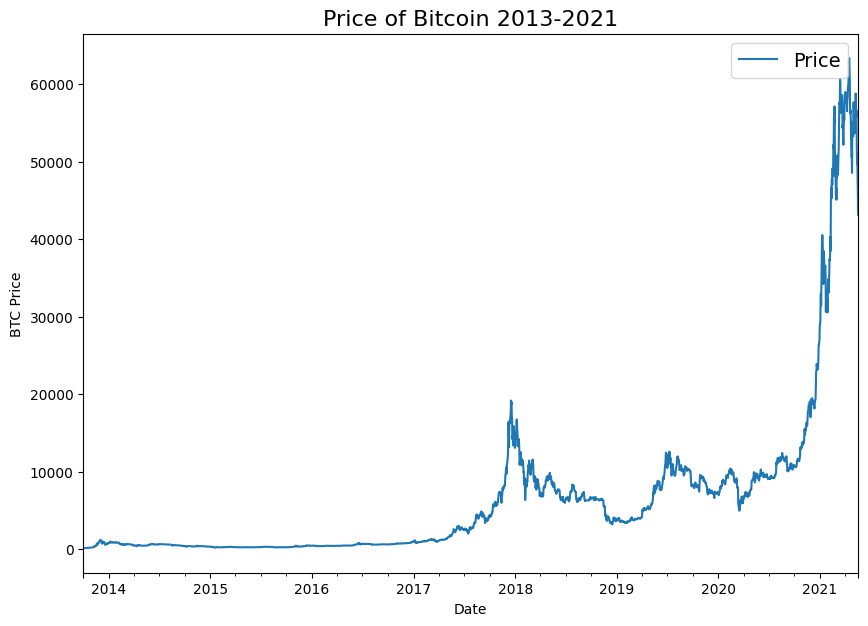

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin 2013-2021", fontsize=16)
plt.legend(fontsize=14)


#Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this is the header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

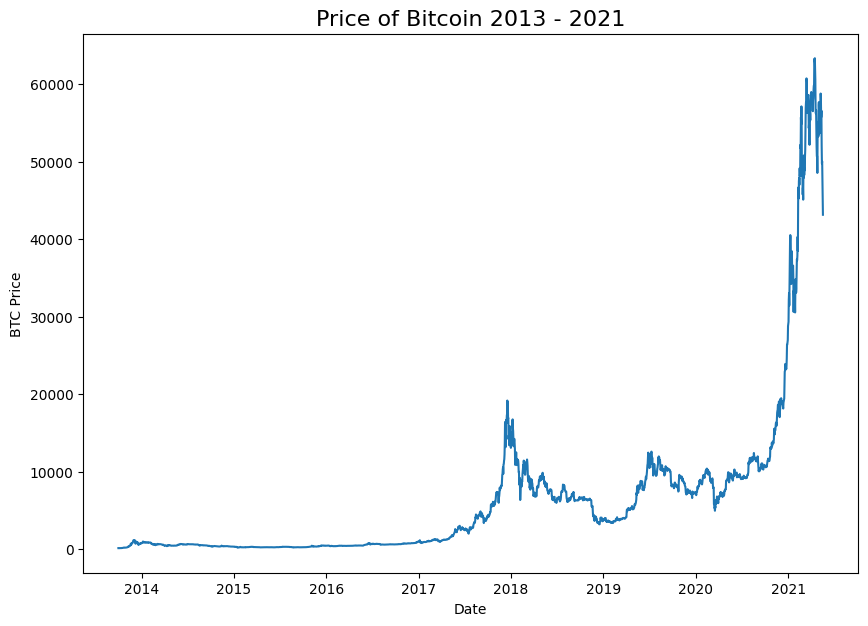

In [8]:

# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin 2013 - 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

#Format Data Part 1: Creating train and test sets for time series data


#Create train & test sets for time series (the wrong way)

In [9]:

# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
prices[:10]

timesteps[:10]

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
       '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
# Wrong way to make train/test sets for time series

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

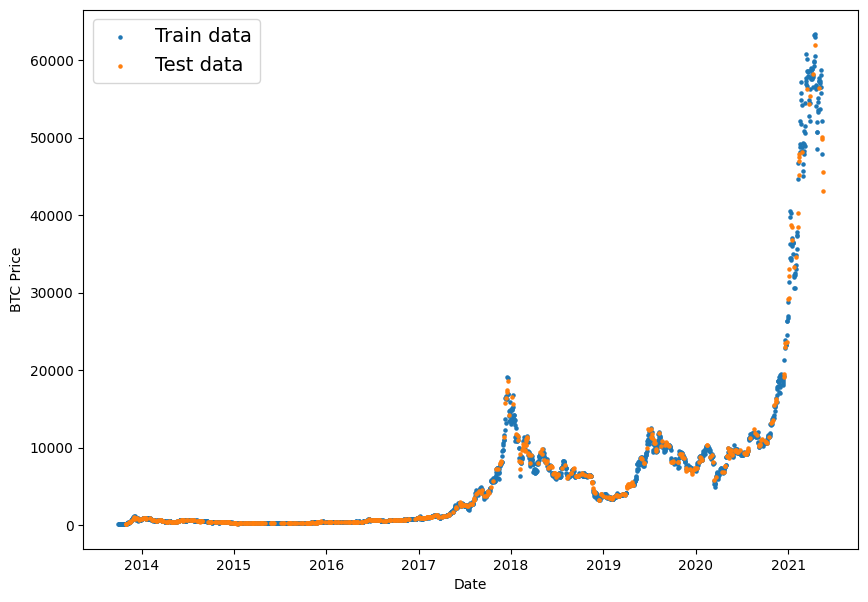

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [12]:
# Create train and test splits the right way for time series data

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

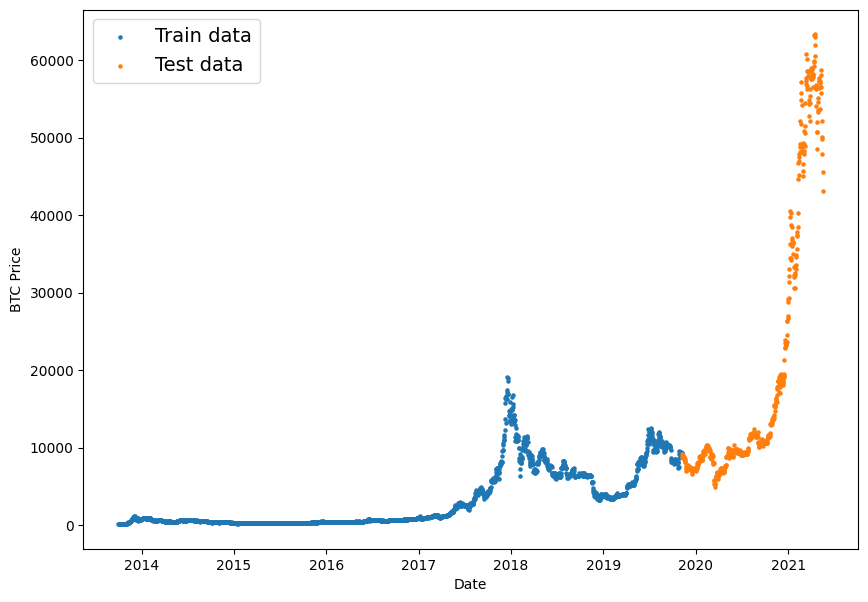

In [13]:

# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

#Create a plotting function

In [14]:
#Create a function to plot time series date
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timesteps values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot of value
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

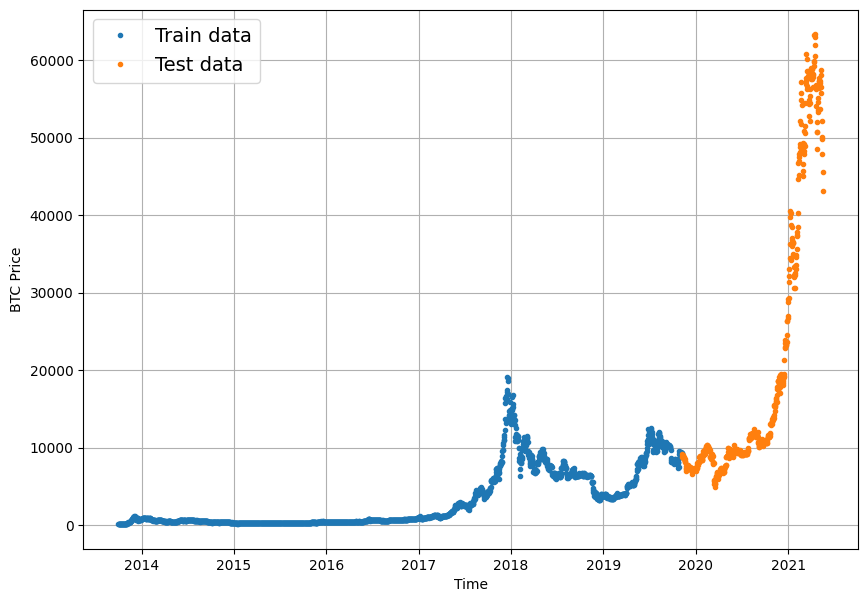

In [15]:

# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

#Modelling Experiments

horizon = number of timesteps to predict into future

window = number of timesteps from past used to predict horizon



#Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

In [16]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

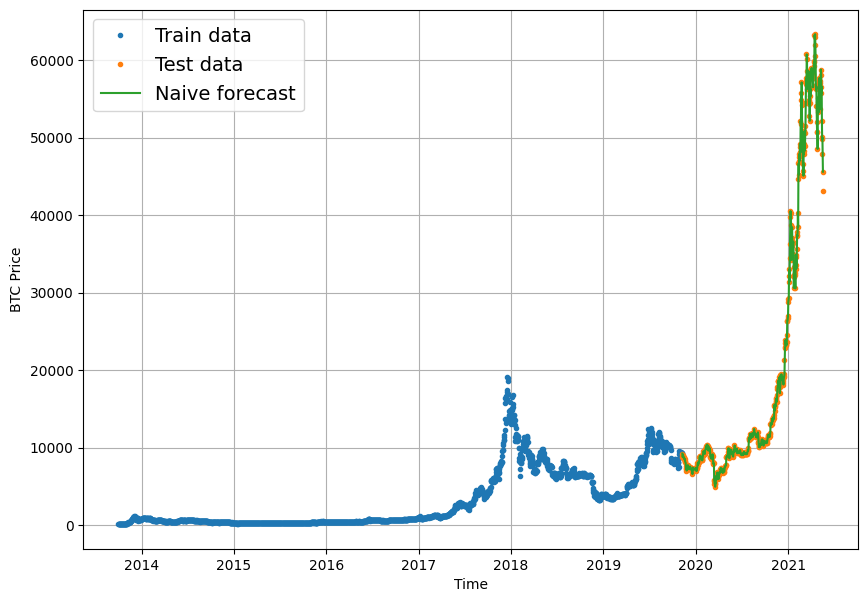

In [17]:

# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train,values=y_train, label="Train data")
plot_time_series(timesteps=X_test,values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast, format="-", label="Naive forecast")

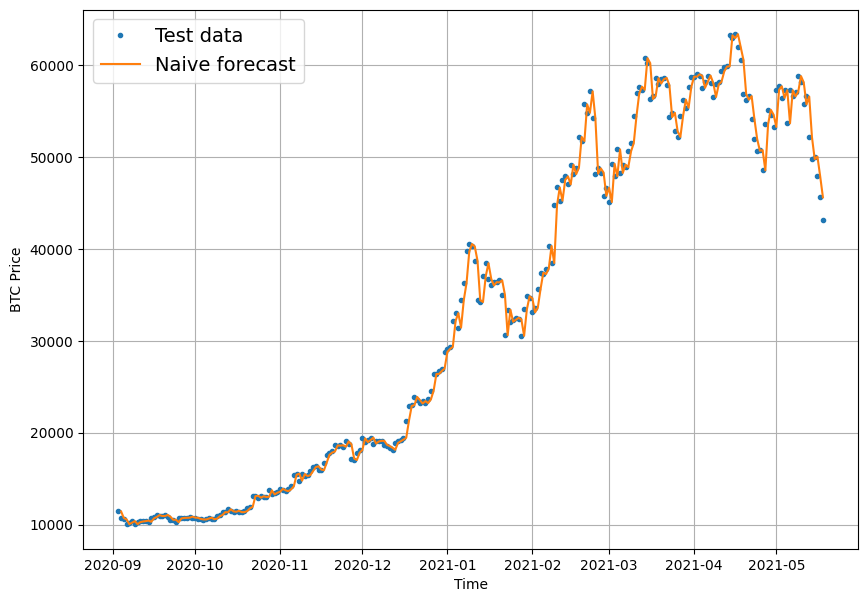

In [18]:
#The naive forecast looks like it's following the data well.

#Let's zoom in to take a better look.

plt.figure(figsize=(10, 7))
offset=300 #offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

#Evaluating a time series model
The main thing we will be evaluating is: how do our model's predictions (y_pred) compare against the actual values (y_true or ground truth values)?

https://otexts.com/fpp3/accuracy.html

Scale-dependent errors

Metric	Details	Code

**MAE** (mean absolute error)	Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median.	tf.keras.metrics.mean_absolute_error()

**RMSE **(root mean square error)	Forecasts which minimise the RMSE lead to forecasts of the mean.	tf.sqrt(tf.keras.metrics.mean_square_error())

Percentage errors

Metric	Details	Code
**MAPE** (mean absolute percentage error)	Most commonly used percentage error. May explode (not work) if y=0.	tf.keras.metrics.mean_absolute_percentage_error()

**sMAPE** (symmetric mean absolute percentage error)	Recommended not to be used by Forecasting: Principles and Practice, though it is used in forecasting competitions.	Custom implementation

Scaled errors

Metric	Details	Code
**MASE **(mean absolute scaled error).	MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE.	See sktime's mase_loss()


In [19]:
import tensorflow as tf

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error for a forecast.

  Note: y_true and y_pred are numpy arrays containing
  the true and predicted values respectively, and must have
  the same lengths.

  Returns the MASE between y_true and y
  """
  # Calculate the mean absolute error
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [21]:
import tensorflow as tf

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(y_true, y_pred) # Update the metric state with the true and predicted values

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(y_true, y_pred) # Update the metric state with the true and predicted values
  rmse = tf.sqrt(mse.result()) # Calculate RMSE from the MSE result

  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  mape.update_state(y_true, y_pred) # Update the metric state with the true and predicted values

  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.result().numpy(),
          "mse": mse.result().numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.result().numpy(),
          "mase": mase.numpy()}



In [22]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

#Format Data Part 2: Windowing dataset

Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]

1.Creates a window step of specific window size, for example:
 [[0, 1, 2, 3, 4, 5, 6, 7]]

2.Uses NumPy indexing to create a 2D of multiple window steps, for example:

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]

3.Uses the 2D array of multuple window steps to index on a target series

4. Uses the get_labelled_windows() function we created above to turn the window steps into windows with a specified horizon

In [23]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [24]:

# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [26]:
import numpy as np

In [27]:
# Create function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"Window step:\n {window_step}")
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(f"Window indexes:\n {window_indexes}")

   # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array=x[window_indexes] # removed extra indent here
  #print(f"Windowed array:\n {windowed_array}")

  #4 Get the labelled windows

  windows, labels=get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [28]:
print(prices.size) # Option 1: Use the size attribute
print(len(prices)) # Option 2: Use the len() function

2787
2787


In [29]:
full_windows, full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:

# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")


Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [31]:

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [34]:

# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

#Make a modelling checkpoint

In [35]:

import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name)+ ".keras", # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

#Model 1: Dense model (window = 7, horizon = 1)

Model_1 will have:

A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation

An output layer with linear activation (or no activation)

Adam optimizer and MAE loss function

Batch size of 128

100 epochs

**Note**: As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called hyperparameters. And experimenting to find the best values for hyperparameters is called hyperparameter tuning. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as parameters.

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1480.1919 - mae: 1480.1919 - val_loss: 2309.7498 - val_mae: 2309.7498
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 286.2095 - mae: 286.2095 - val_loss: 938.6924 - val_mae: 938.6924
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 175.8100 - mae: 175.8100 - val_loss: 947.2532 - val_mae: 947.2532
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.6064 - mae: 164.6064 - val_loss: 931.6365 - val_mae: 931.6365
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 159.6864 - mae: 159.6864 - val_loss: 935.2712 - val_mae: 935.2712
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 158.0397 - mae: 158.0397 - val_loss: 911.5080 - val_mae: 911.5080
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 155.2103 - mae: 155.2103 - val_loss: 881.2808 - val_mae: 881.2808
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 152.2936 - mae: 152.2936 - val_loss: 857.6854 - val_mae: 857.

In [37]:
#Evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 286.0936 - mae: 286.0936


[575.1102905273438, 575.1102905273438]

In [38]:
# Load in saved best performing model_1 and evaluate on test data
model_1=tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 285.0635 - mae: 285.0635


[571.0744018554688, 571.0744018554688]

#Making forecasts with a model (on the test dataset)
write a function which:

Takes in a trained model (just like model_1)

Takes in some input data (just like the data the model was trained on)

Passes the input data to the model's predict() method

Returns the predictions

In [39]:
def make_preds(model,input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast=model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [40]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8871.291 , 8778.347 , 9042.454 , 8811.093 , 8714.7705, 8744.37  ,
        8690.028 , 8520.745 , 8463.931 , 8529.77  ], dtype=float32)>)

In [41]:
# Evaluate preds
model_1_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_1_preds)
model_1_results


{'mae': 571.07446,
 'mse': 1182711.2,
 'rmse': 1087.5253,
 'mape': 2.5519996,
 'mase': 1.0032196}

In [42]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

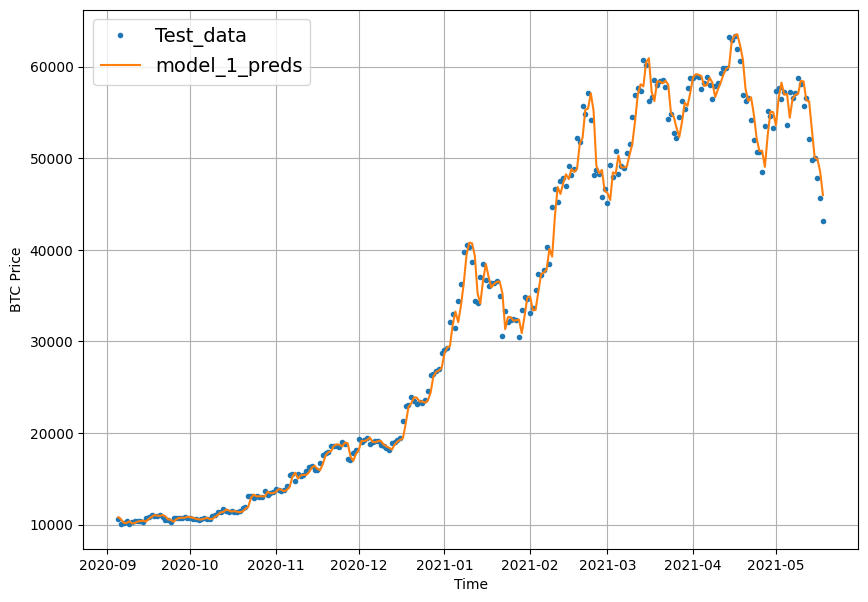

In [43]:
offset=300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")


What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.



#Model 2: Dense (window = 30, horizon = 1)

In [44]:
HORIZON=1  # predict one step at a time
WINDOW_SIZE=30 # use 30 timesteps in the past

In [45]:
# Make windowed data with appropriate horizon and window sizes
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [46]:
# Make train and testing windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(windows=full_windows,labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [47]:
tf.random.set_seed(42)
# Create model (same model as model 1 but data input will be different)
model_2=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                )

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


In [48]:
model_2.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 307.8279


601.789306640625

In [49]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 305.1140


599.3663330078125

In [50]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [51]:

# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 599.3664,
 'mse': 1261562.2,
 'rmse': 1123.1929,
 'mape': 2.718087,
 'mase': 1.0476984}

In [52]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

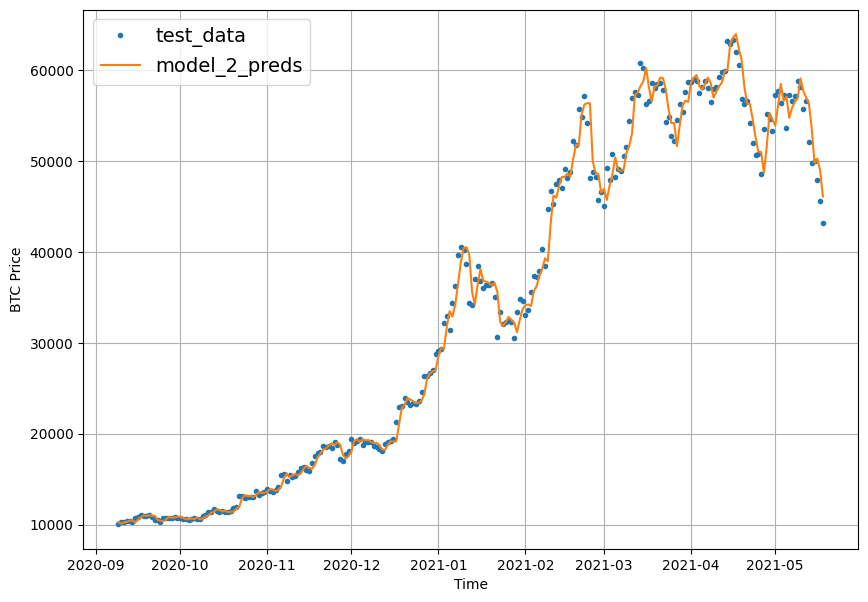

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")


#Model 3: Dense (window = 30, horizon = 7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [55]:
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(windows=full_windows,labels=full_labels,test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [56]:
tf.random.set_seed(42)

#Create model
model_3=tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
],name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
model_3.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 629.1061


1242.1243896484375

In [58]:
#Load the best version of model 3
model_3=tf.keras.models.load_model("/content/model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 621.6040


1234.865966796875

In [59]:
model_3_preds=make_preds(model_3,input_data=test_windows)
model_3_preds[:3]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[9422.713, 9583.841, 9536.295, 9388.972, 9291.802, 9325.947,
        9202.694],
       [8986.202, 9228.031, 9218.966, 9147.119, 9085.042, 9075.545,
        8815.703],
       [8782.865, 8807.359, 9013.08 , 8845.408, 8872.781, 8932.944,
        8583.302]], dtype=float32)>

In [60]:
model_3_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_3_preds)
model_3_results

{'mae': 1234.8658,
 'mse': 5325528.5,
 'rmse': 2307.7107,
 'mape': 5.550686,
 'mase': 2.1973748}

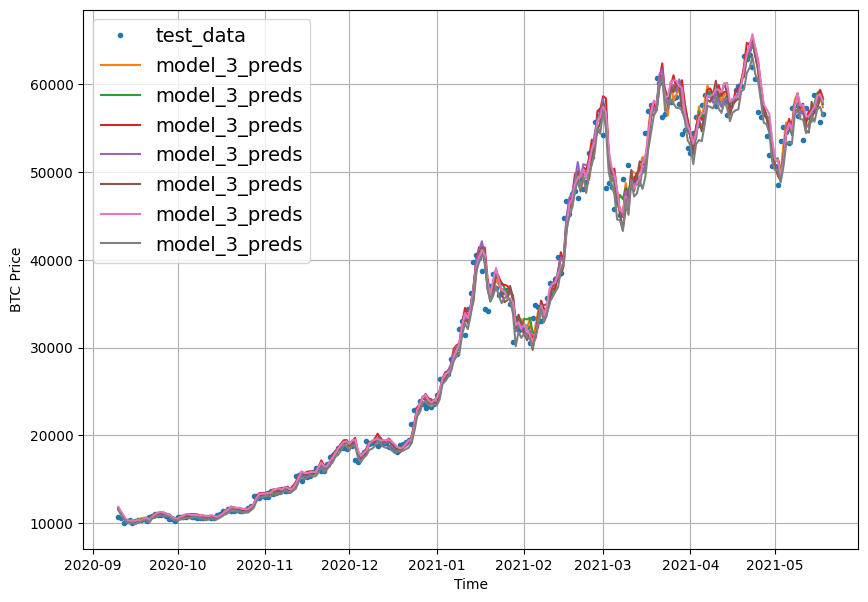

In [61]:
offset=300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format="-", label="model_3_preds")

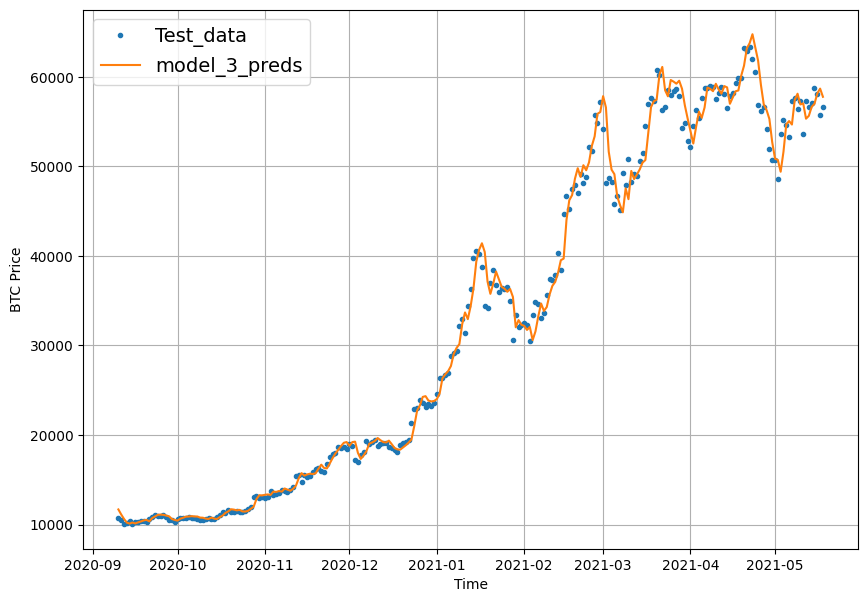

In [62]:

offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

#Models comparison

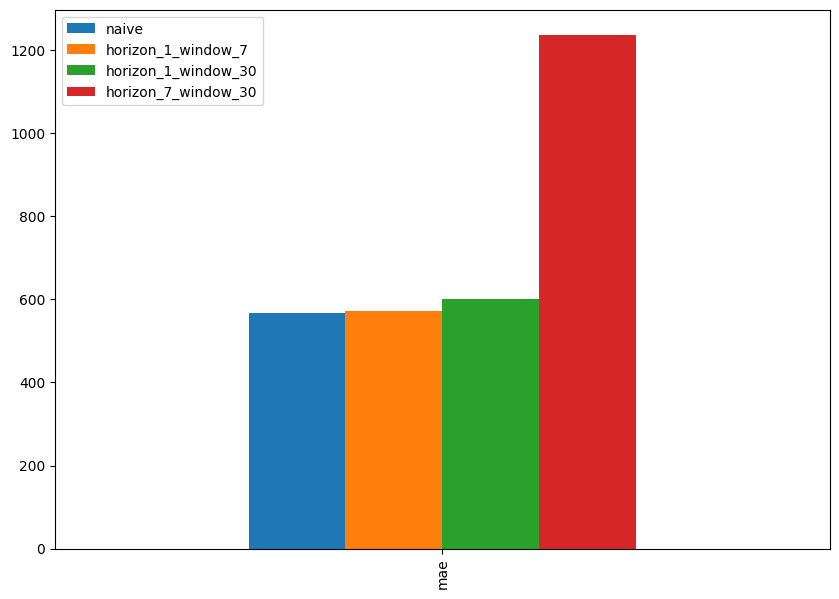

In [63]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

#Model 4: Conv1D

In [64]:
HORIZON=1
WINDOW_SIZE=7

In [65]:
# Create windowed dataset
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [66]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case, the batch_size (by default this is 32 but we can change it) is handled for us but the other values will be:

timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin
input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)
Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [67]:
#Data sample shape
train_windows[0].shape

(7,)

In [68]:
#Reshape the sample
x=tf.constant(train_windows[0])
expand_dims_layer=layers.Lambda(lambda x:tf.expand_dims(x,axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [71]:

# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8894.288 , 8823.563 , 9050.673 , 8814.23  , 8780.087 , 8753.04  ,
       8706.9795, 8568.831 , 8482.308 , 8553.937 ], dtype=float32)>

In [72]:

# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 565.8193,
 'mse': 1167273.9,
 'rmse': 1080.4044,
 'mape': 2.5340102,
 'mase': 0.99398774}

#Model 5: RNN (LSTM)

In [73]:
tf.random.set_seed(42)

# Define the input layer
inputs = layers.Input(shape=(WINDOW_SIZE,))

# Reshape the input to a 3D tensor with a single feature dimension
x = layers.Reshape((WINDOW_SIZE, 1))(inputs)

# Add the LSTM layer
x = layers.LSTM(128, activation="relu")(x)

# Add the output layer
output = layers.Dense(HORIZON)(x)

# Create the model
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit the model (unchanged)
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [74]:
#Load best version of model _5
model_5=tf.keras.models.load_model("/content/model_experiments/model_5_LSTM.keras",safe_mode=False)
model_5.evaluate(test_windows,test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 343.9819


674.4701538085938

In [75]:
#Make predictions
model_5_preds=make_preds(model_5,test_windows)
model_5_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([9151.037, 8950.59 , 8966.863, 8914.12 , 8855.01 ], dtype=float32)>

In [76]:
#Evaluate model5 preds
model_5_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_5_preds)
model_5_results

{'mae': 674.47015,
 'mse': 1571978.1,
 'rmse': 1253.7855,
 'mape': 3.0772607,
 'mase': 1.1848572}

#Make a multivariate time series
 Note: Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [77]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [78]:

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [79]:
# Get date indexes for when to add in different block dates
block_reward_2_days=(block_reward_3_datetime-bitcoin_prices.index[0]).days
block_reward_3_days=(block_reward_4_datetime-bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [80]:
# Add block_reward column
bitcoin_prices_block=bitcoin_prices.copy()
bitcoin_prices_block["block_reward"]=None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days,-1]=block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]=block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1]=block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<Axes: xlabel='Date'>

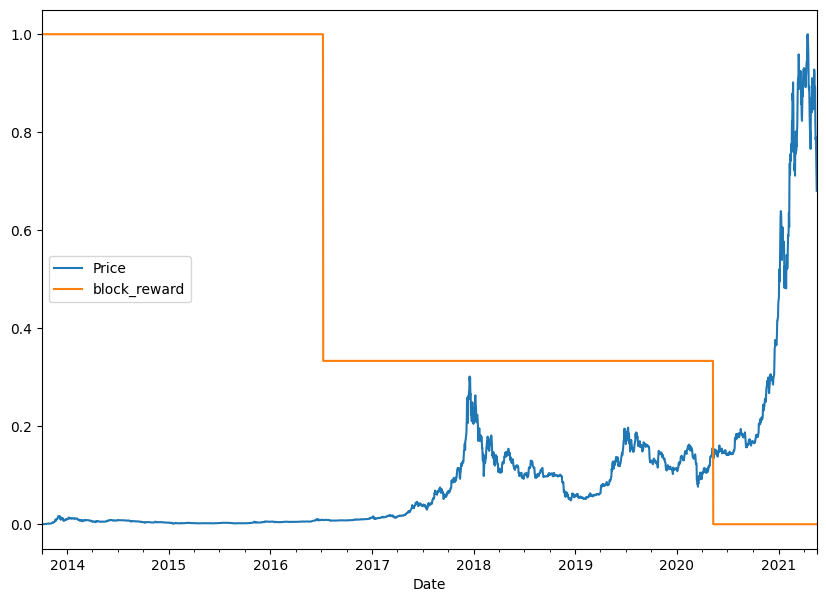

In [81]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df=pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),# we need to scale the data first
                                   columns=bitcoin_prices_block.columns,
                                   index=bitcoin_prices_block.index
)

scaled_price_block_df.plot(figsize=(10,7))

#Making a windowed dataset with pandas

Since our data is in a pandas DataFrame, we can leverage the pandas.DataFrame.shift() method to create a windowed multivariate time series.

The shift() method offsets an index by a specified number of periods.

In [82]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7


In [83]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed=bitcoin_prices_block.copy()

#Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"]=bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [84]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
#We'll also remove the NaN values using pandas dropna() method, this equivalent to starting our windowing function at sample 0 (the first sample) + WINDOW_SIZE.
x=bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y=bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
x.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [85]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [86]:
# Make train and test sets
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

#Model 6: Dense (multivariate time series)

In [87]:
tf.random.set_seed(42)

tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(x_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [88]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(x_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 284.7689


569.3178100585938

In [89]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8793.137 , 8757.896 , 9022.5205, 8715.74  , 8699.668 , 8704.607 ,
       8629.969 , 8490.701 , 8419.44  , 8501.127 ], dtype=float32)>

In [90]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 569.3178,
 'mse': 1160348.8,
 'rmse': 1077.1948,
 'mape': 2.5736039,
 'mase': 1.0001338}

In [91]:
model_1_results

{'mae': 571.07446,
 'mse': 1182711.2,
 'rmse': 1087.5253,
 'mape': 2.5519996,
 'mase': 1.0032196}

#Model 7: N-BEATS algorithm
 One of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the M4 competition (a forecasting competition).

https://arxiv.org/pdf/1905.10437




https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fn-beats-time-series-forecasting-with-neural-basis-expansion-af09ea39f538&psig=AOvVaw2e_h5QDrc6bR3aXPxE3Klu&ust=1723722027534000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCMD_54qz9IcDFQAAAAAdAAAAABAE


#Building and testing an N-BEATS block layer

In [92]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size=input_size
    self.theta_size=theta_size
    self.horizon=horizon
    self.n_neurons=n_neurons
    self.n_layers=n_layers

    #Block contains atack of 4 fully connected layers with Relu activation
    self.hidden=[tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]
    #Output of block is a theta layer with liniar activation
    self.theta_layer=tf.keras.layers.Dense(theta_size,activation='linear',name="theta")

  def call(self,inputs): # the call method is what runs when the layer is called
    x=inputs
    for layer in self.hidden:
      x=layer(x)
    theta=self.theta_layer(x)
    #Output the backcast and forcast from theta
    backcast, forecast=theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast,forecast

Setting up the NBeatsBlock custom layer we see:

The class inherits from tf.keras.layers.Layer (this gives it all of the methods assosciated with tf.keras.layers.Layer)

The constructor (def __init__(...)) takes all of the layer hyperparameters as well as the **kwargs argument

The **kwargs argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, input_shape, trainable and name

In the constructor, the block architecture layers are created:

The hidden layers are created as a stack of fully connected with n_nuerons hidden units layers with ReLU activation

The theta layer uses theta_size hidden units as well as linear activation

The call() method is what is run when the layer is called:

It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)

After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: input_size) and forecast (forward predictions, shape: horizon) are returned

In [93]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer=NBeatsBlock(input_size=WINDOW_SIZE,
                                     theta_size=WINDOW_SIZE+HORIZON,# backcast + forecast
                                     horizon=HORIZON,
                                     n_neurons=128,
                                     n_layers=4)

In [94]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs=tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [95]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast=dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.3026716  -0.3990612   1.0060954  -0.47155872  0.39151868  0.02128353
 -0.02635321]
Forecast: 0.5788998603820801


#Preparing data for the N-BEATS algorithm using tf.data

In [96]:
HORIZON=1
WINDOW_SIZE=7

In [97]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [98]:
#Add windowed columns
bitcoin_prices_nbeats=bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"]=bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [99]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now let's convert them into TensorFlow tf.data.Dataset's to ensure they run as fast as possible whilst training.

We'll do this by:


Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices()

Note: from_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord forma
t
Combine the labels and features tensors into a Dataset using tf.data.Dataset.zip()

Batch and prefetch the Datasets using batch() and prefetch()

Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

📖 Resource: For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the Better performance with the tf.data API guide.

In [100]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#Setting up hyperparameters for N-BEATS algorithm

In [101]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

#Getting ready for residual connections

The power of residual stacking or residual connections was revealed in Deep Residual Learning for Image Recognition (https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular ResNet architecture(https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.


A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

Subtract the backcast outputs from a previous block from the backcast inputs to the current block

Add the forecast outputs from all blocks together in a stack


In [102]:
#Make tensors
tensor_1=tf.range(10)+10
tensor_2=tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


#Building, compiling and fitting the N-BEATS algorithm

1.Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)

2.Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)

3.Make the initial backcast and forecasts for the model with the layer created in (1)
4.Use a for loop to create stacks of block layers

5.Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts

6.Create the double residual stacking using subtract and add layers

7.Put the model inputs and outputs together using tf.keras.Model()

8.Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)

9.Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)

tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [103]:
tf.random.set_seed(42)

#1 Setup N-Beats Block layer

nbeats_block_layer=NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

#2 Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast,forecast=nbeats_block_layer(stack_input)

# Add in subtraction residual link
residuals=layers.subtract([stack_input,backcast], name=f"substract_00")

#4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  #5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast=NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  #6. Create the double residual stacking
  residuals=layers.subtract([residuals,backcast], name=f"substract_{i}")
  forecast=layers.add([forecast,block_forecast], name=f"add_{i}")

#7. Put the stack model togeter
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

#8. Compile

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

#9. Fit the model
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=100,verbose=1)])



Epoch 208: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 308: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [104]:
#Evaluate model
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 572.7133 - mae: 572.7133 - mse: 1136840.1250


[572.7132568359375, 572.7132568359375, 1136840.125]

In [105]:
#Make predictions
model_7_preds=make_preds(model_7,test_dataset)
model_7_preds[:5]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([8929.6455, 8830.552 , 8996.745 , 8780.501 , 8738.921 ],
      dtype=float32)>

In [106]:
#Evaluate
model_7_results=evaluate_preds(y_true=y_test,
                               y_pred=model_7_preds)
model_7_results

{'mae': 572.7132,
 'mse': 1136840.1,
 'rmse': 1066.227,
 'mape': 2.6325772,
 'mase': 1.0060985}

In [107]:
model_1_results

{'mae': 571.07446,
 'mse': 1182711.2,
 'rmse': 1087.5253,
 'mape': 2.5519996,
 'mase': 1.0032196}

#Plotting the N-BEATS architecture we've created

In [108]:
!apt-get -qq install -y graphviz # Install Graphviz if not already installed
!pip install pydot

from tensorflow.keras.utils import plot_model

# Try saving the plot to a file instead of displaying it directly
plot_model(model_7, to_file='model_7.png', show_shapes=True)

# Display the saved image
from IPython.display import Image
Image('model_7.png')

#Model 8: Creating an ensemble (stacking different models together)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can take the average or median of many different models.
https://en.wikipedia.org/wiki/Ensemble_forecasting

To create our ensemble models we're going to be using a combination of:

Different loss functions (MAE, MSE, MAPE)

Randomly initialized models

Essentially, we'll be creating a suite of different models all attempting to model the same data.

In [109]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensamble models

  ensemble_models=[]

  #Create num_iter number of models per loss function

  for i in range(num_iter):
    #Build and fit a new model with a different loss function
    for loss_fn in loss_fns:
       print(f"Optimizing model by reducing: {loss_fn} for {num_epochs} epochs, model number: {i}")

       #Construct a simple model similar o model_1
       model=tf.keras.Sequential([
           # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
           # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
           layers.Dense(128,activation="relu",kernel_initializer='he_normal'),
           layers.Dense(128,activation="relu",kernel_initializer='he_normal'),
           layers.Dense(horizon)
       ])

       #Compile
       model.compile(loss=loss_fn,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["mae","mse"])

       #Fit the model
       model.fit(train_data,
                 epochs=num_epochs,
                 verbose=0,
                 validation_data=test_data,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                             patience=200,
                                                             restore_best_weights=True),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                 patience=100,
                                                                 verbose=1)])
       #Append fitted model to list ofensemble models
       ensemble_models.append(model)

  return ensemble_models

In [110]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 493: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 455: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 555: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 203: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 303: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 122: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 928: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 176: ReduceLROnPlateau reduci

In [111]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models,data):
  ensemble_preds=[]
  for model in ensemble_models:
    preds=model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [112]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8778.442,  8765.71 ,  9049.601, ..., 49846.777, 48890.633,
        45921.484],
       [ 8779.837,  8757.164,  9046.375, ..., 49752.48 , 48286.336,
        45866.65 ],
       [ 8770.753,  8791.379,  9073.753, ..., 49534.402, 47544.8  ,
        46330.613],
       ...,
       [ 8803.431,  8800.951,  9089.376, ..., 49677.254, 48202.105,
        45720.12 ],
       [ 8768.723,  8733.454,  9058.548, ..., 49708.55 , 47991.97 ,
        46728.09 ],
       [ 8808.062,  8797.692,  9065.43 , ..., 49995.223, 48386.1  ,
        45613.46 ]], dtype=float32)>

In [113]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 570.0223,
 'mse': 1158140.4,
 'rmse': 1076.1693,
 'mape': 2.5886583,
 'mase': 1.0013713}

In [114]:
model_1_results

{'mae': 571.07446,
 'mse': 1182711.2,
 'rmse': 1087.5253,
 'mape': 2.5519996,
 'mase': 1.0032196}

#Plotting the prediction intervals (uncertainty estimates) of our ensemble

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)

Measure the standard deviation of the predictions

Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)

To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [115]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

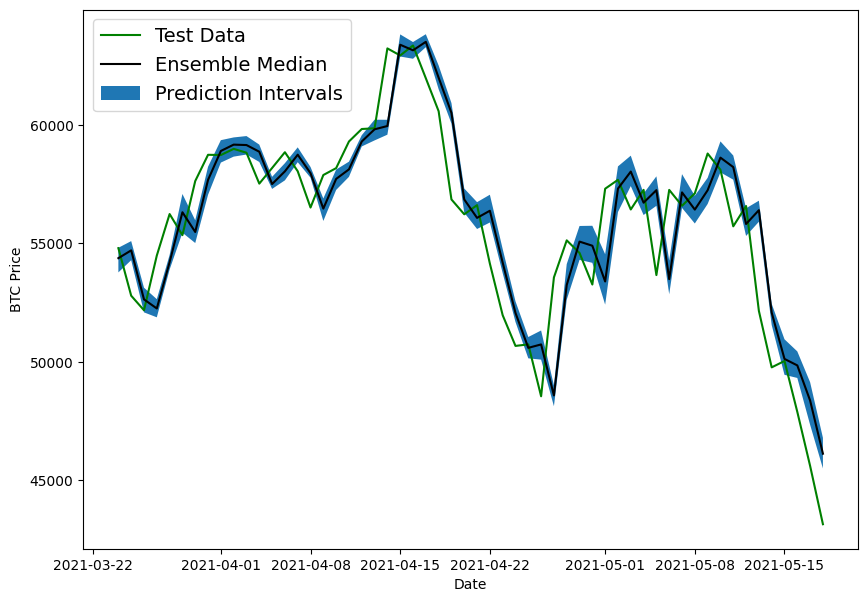

In [116]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.
Aside: two types of uncertainty (coconut and subway)
Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a point prediction, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a prediction interval or uncertainty estimate can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.
The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

Uncertainty in dating
Let's say you're going on a First Date Feedback Radio Show to help improve your dating skills.

Where you go on a blind first date with a girl (feel free to replace girl with your own preference) and the radio hosts record the date and then playback snippets of where you could've improved.

And now let's add a twist.

Last week your friend went on the same show. They told you about the girl they met and how the conversation went.

Because you're now a machine learning engineer, you decide to build a machine learning model to help you with first date conversations.

What levels of uncertainty do we have here?

From an aleatory uncertainty (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an epistemic uncertainty (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

However, the level of epistemic uncertainty would be reduced if your friend told about the girl they went on a date with last week on the show and it turns out you're going on a date with the same girl.

But even though you know a little bit about the girl, your aleatory uncertainty (or subway uncertainty) is still high because you're not sure where the conversation will go.

If you're wondering where above scenario came from, it happened to me this morning. Good timing right?

Learning more on uncertainty
The field of quantifying uncertainty estimation in machine learning is a growing area of research.

If you'd like to learn more I'd recommend the following.

📖 Resources: Places to learn more about uncertainty in machine learning/forecasting:

🎥 MIT 6.S191: Evidential Deep Learning and Uncertainty

Uncertainty quantification on Wikipedia

Why you should care about the Nate Silver vs. Nassim Taleb Twitter war by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.

3 facts about time series forecasting that surprise experienced machine learning practitioners by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.

Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.

#Model 9: Train a model on the full historical data to make predictions into future

To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon.

In [116]:
bitcoin_prices_windowed.head()

In [117]:
# Train model on entire data to make prediction for the next day
X_all=bitcoin_prices_windowed.drop(["Price","block_reward"],axis=1).dropna().to_numpy()
y_all=bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [119]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all=tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE=1024
dataset_all=dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>